# Easier Model Serving with Ray Serve and zerocopy

In a [previous post](https://medium.com/ibm-data-ai/how-to-load-pytorch-models-340-times-faster-with-ray-8be751a6944c), we introduced the concept of *zero-copy model loading*. Zero-copy model loading involves keeping the weights of a machine learning model in shared memory so that different processes can load the model for inference instantly without copying data.

We showed that the Plasma object store integrated into [Ray](https://www.ray.io/) makes it easy to do zero-copy model loading, and that implementing this technique on Ray can accelerate model loading by several orders of magnitude. If you'd like to find out more about the details of zero-copy model loading, follow [this link](https://medium.com/ibm-data-ai/how-to-load-pytorch-models-340-times-faster-with-ray-8be751a6944c) to view the previous post.

In this follow-on post, we focus on how zero-copy model loading with Ray lets you deploy models in production with fewer resources, fewer knobs to tune, and better performance. We introduce `zerocopy`, a Python package that makes it extra simple to apply the technique. We show how to deploy models using with `zerocopy` and Ray Serve. And then we present an end-to-end model serving benchmark that shows how we can serve multiple large NLP models with a single cloud VM and achieve 7x better scalability with no tuning.

In [1]:
# Initialization and import code goes in this cell.

# Imports: Python core, then third-party, then local.
# Try to keep each block in alphabetical order, or the linter may get angry.

import asyncio
import concurrent.futures
import requests
import starlette
import time
import os
import json
import multiprocessing

import matplotlib.pyplot as plt
import pandas as pd

import ray
from ray import serve
import torch
import transformers

import zerocopy

# Fix silly warning messages about parallel tokenizers
os.environ['TOKENIZERS_PARALLELISM'] = 'False'


# Reduce the volume of warning messages from `transformers`
transformers.logging.set_verbosity_error()


def reboot_ray():
    if ray.is_initialized():
        ray.shutdown()

    if torch.cuda.is_available():
        return ray.init(num_gpus=1)
    else:
        return ray.init()

In [2]:
# Don't include this cell in the blog post.
# Fire up Ray
serve.shutdown()
reboot_ray()
serve.start()

# Wait a moment to make sure that all log output goes to this cell
time.sleep(1.)

2022-04-01 10:00:24,190	INFO services.py:1412 -- View the Ray dashboard at http://127.0.0.1:8265
(ServeController pid=84618) 2022-04-01 10:00:29,489	INFO checkpoint_path.py:16 -- Using RayInternalKVStore for controller checkpoint and recovery.
(ServeController pid=84618) 2022-04-01 10:00:29,593	INFO http_state.py:98 -- Starting HTTP proxy with name 'SERVE_CONTROLLER_ACTOR:Gdwiai:SERVE_PROXY_ACTOR-node:127.0.0.1-0' on node 'node:127.0.0.1-0' listening on '127.0.0.1:8000'
2022-04-01 10:00:30,030	INFO api.py:521 -- Started Serve instance in namespace 'ba7da799-0818-4b38-be80-0efbd71c4fe7'.
(HTTPProxyActor pid=84617) INFO:     Started server process [84617]


## Introducing `zerocopy`

Our previous post included code snippets that show how to rewrite a PyTorch model to use zero-copy model loading. 
We've recently released a Python package, [`zerocopy`](https://pypi.org/project/zerocopy), that lets you apply this technique to your models without having to copy and paste Python code. 
This package is part of IBM's [Project Codeflare](https://github.com/project-codeflare), a framework to simplify the integration, scaling and acceleration of complex multi-step analytics and machine learning pipelines.

You can install this package by typing:

```
pip install zerocopy
```

Once it's installed, using the `zerocopy` package is a three-step process:
1. Import the package.
2. Move your model's weights onto the Plasma object store.
3. Run your model in an asynchronous Ray task.

Let's show these three steps in action. 

Step 1 is just a Python `import` statement:
```python 
import zerocopy
```

Then it's on to step 2: Moving your model's weights onto Plasma. You will of course need a PyTorch model to do this step. As an example, let's load up the most popular [intent detection](https://paperswithcode.com/task/intent-detection) model from the [Huggingface model marketplace](https://huggingface.co/models).

In [3]:
model = transformers.AutoModelForSeq2SeqLM.from_pretrained(
            'mrm8488/t5-base-finetuned-e2m-intent')

In [4]:
# Don't include this cell in the blog.
# Load a tokenizer to go with the model and generate some preprocessed
# model inputs
tokenizer = transformers.AutoTokenizer.from_pretrained('t5-base')
text = ("I came here to eat chips and beat you up, "
        "and I'm all out of chips.")
model_input = tokenizer(text, return_tensors='pt')
model_input

{'input_ids': tensor([[  27,  764,  270,   12,    3, 1544, 8852,   11, 3853,   25,   95,    6,
           11,   27,   31,   51,   66,   91,   13, 8852,    5,    1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

To move this model's weights onto Plasma, you first need to pass the model through `zerocopy.extract_tensors()`, which separates the weights from the model's Python objects. Then you need to copy the model and its weights to Plasma using the function `ray.put()`. You can do both of these operations with a single line of Python code. 

In [5]:
model_ref = ray.put(zerocopy.extract_tensors(model))

The return value from `ray.put()` is a Ray [object reference](https://arrow.apache.org/docs/python/plasma.html#object-ids). This object reference lets you load the model almost instantly from any location on your Ray cluster. This capability is what enables step 3: Running your model in an asynchronous Ray task.

In our previous post, we showed how you can define a stateless Ray task that loads the model, runs inference over an input, and returns the result. The `zerocopy` package includes a built-in function `call_model()` that lets you do all these steps in one line of code.

In [6]:
# Invoke the model's `generate()` method from a remote Ray task
result_ref = zerocopy.call_model.remote(model_ref, [], model_input,
                                        'generate')

As with any other Ray task, `call_model.remote()` returns a [future](https://docs.ray.io/en/latest/ray-overview/index.html#parallelizing-python-java-functions-with-ray-tasks) --- a Ray object reference to the place where the result will appear once the task has completed. You can retrieve this result with `ray.get()`.

In [7]:
ray.get(result_ref)

tensor([[   0,   12,    3, 1544, 8852,    1]])

The time to invoke the rewritten model is almost the same as running the model locally. If you run inference multiple times, `zero_copy.call_model()` can send those inference requests to separate Ray tasks that run in parallel.

In [14]:
print("            Time to run once locally: ", end="")
%timeit model.generate(**model_input)
print("     Time to run once with zero-copy: ", end="")
%timeit ray.get(zerocopy.call_model.remote(model_ref, [], model_input, 'generate'))

NUM_REPEATS = 100
print(f"       Time to run {NUM_REPEATS} times locally: ", end="")
%timeit [model.generate(**model_input) for _ in range(NUM_REPEATS)]
print(f"Time to run {NUM_REPEATS} times with zero-copy: ", end="")
%timeit ray.get([zerocopy.call_model.remote(model_ref, [], model_input, 'generate') for _ in range(NUM_REPEATS)])

            Time to run once locally: 330 ms ± 11.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
     Time to run once with zero-copy: 328 ms ± 8.87 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
       Time to run 100 times locally: 33.1 s ± 1.04 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
Time to run 100 times with zero-copy: 13.9 s ± 463 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
# Don't include this cell in the blog.
# More in-depth benchmarking for internal use.
# TODO: Use output from running this cell on a large machine for the blog post
def run_local(num_repeats: int):
    for _ in range(num_repeats):
        model.generate(**model_input)


def run_zero_copy(num_repeats: int):
    futures = [
        zerocopy.call_model.remote(model_ref, [],
                                   model_input, 'generate')
        for _ in range(num_repeats)]
    ray.get(futures)


def run_zero_copy_2(num_repeats: int):
    num_cores = multiprocessing.cpu_count()
    num_not_started = num_repeats
    futures = []
    # Keep `num_cores` tasks live at a time
    while num_not_started > 0:
        addl_futures = [
            zerocopy.call_model.remote(model_ref, [],
                                       model_input, 'generate')
            for _ in range(min(num_not_started, num_cores - len(futures)))]
        num_not_started -= len(addl_futures)
        futures.extend(addl_futures)
        ready, futures = ray.wait(futures)
        ray.get(ready)
    # Fetch remaining results
    ray.get(futures)


NUM_REPEATS = 50
print(f"Time to run {NUM_REPEATS} times with zero-copy 2: ", end="")
%timeit -r 3 run_zero_copy_2(NUM_REPEATS)
print(f"Time to run {NUM_REPEATS} times with zero-copy: ", end="")
%timeit -r 3 run_zero_copy(NUM_REPEATS)
print(f"       Time to run {NUM_REPEATS} times locally: ", end="")
%timeit -r 3 run_local(NUM_REPEATS)

Time to run 50 times with zero-copy 2: 7.19 s ± 130 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Time to run 50 times with zero-copy: 7.07 s ± 216 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
       Time to run 50 times locally: 17.3 s ± 577 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


## A better way to deploy models

In a world without zero-copy model loading, anyone who runs deep learning models in production encounters a common set of design constraints. To run inference on a model, you need to have the model's weights loaded into a process's memory. But loading the model from storage is orders of magnitude more expensive than running inference. So you need to keep the model perpetually loaded in a process's memory. This process needs to have enough CPU and memory resources so that it can run inference when it is called upon to do so.

These constraints are why systems like [TorchServe](https://github.com/pytorch/serve/blob/master/docs/management_api.md), [TensorFlow Serving](https://www.tensorflow.org/tfx/serving/serving_kubernetes), and [Seldon Core](https://docs.seldon.io/projects/seldon-core/en/latest/workflow/overview.html#e2e-serving-with-model-servers) run each model in its own container, or equivalently in a UNIX process with reserved CPU and memory resources.

**TODO: Find and insert an appropriate block diagram here**

It is possible to achieve good response times and low costs with this design, but you will need to tune many parameters to arrive at that point. How much CPU and memory capacity should you reserve for each model's containers? How many replicas of each container should you keep up at all times? How quickly should you spin up additional replicas in response to changing loads? How quickly should you spin down replicas when they aren't being used? How do you even measure the current load? All of these important decisions take time and energy.

Zero-copy model loading with Ray turns model inference into a stateless process. As long as the weights are in the local segment of the Plasma object store, your code can load a copy of the model instantly, run a single inference request, and then unload the model. This statelessness removes the design constraints that underlie conventional model serving systems. With zero-copy loading, there's no need to manage a pool of containers. Just load all the model weights onto Plasma and let Ray take care of replicating objects to nodes of the cluster as needed.

A small Ray cluster can keep the weights for hundreds of models in shared memory. It can instantly dedicate the entire cluster's CPU resources to a single model. Then it can just as quickly retask all of those resources to a different model. You get an instant, optimal response to whatever workload the application sends your way. And no manual tuning is required.

The best part about this approach is that deploying models with Ray and zero-copy is actually *easier* than deploying them with a traditional model serving framework. Here's the code to deploy our example model.

In [10]:
from ray import serve


# Step 1: Define a Ray Serve deployment
@serve.deployment
class MyDeployment:
    def __init__(self):
        transformers.logging.set_verbosity_error()
        self._tokenizer = transformers.AutoTokenizer.from_pretrained('t5-base')

        # Load the model and immediately move it to Plasma
        model = transformers.AutoModelForSeq2SeqLM.from_pretrained(
            'mrm8488/t5-base-finetuned-e2m-intent')
        self._model_ref = zerocopy.extract_tensors(model)

    async def __call__(self, request: starlette.requests.Request):
        '''
        Web service entry point.

        Args:
            request: HTTP request object for a REST web service call
                     in the form:
                     { "context": "<input text>" }
        '''
        # Parse JSON. A real deployment would also sanitize the input.
        json_request = await request.json()
        text = json_request['context']

        # Preprocessing
        tokens = self._tokenizer(text, return_tensors='pt')

        # Model inference runs asynchronously in a Ray task
        raw_output = await zerocopy.call_model.remote(
            self._model_ref, [], tokens, 'generate')

        # Postprocessing
        result_string = self._tokenizer.decode(raw_output[0])
        result_string = result_string.replace('<pad>', '')
        result_string = result_string[len(' '):-len('</s>')]

        return {'intent': result_string}


# Step 2: Attach the deployment to an HTTP endpoint
MyDeployment.options(name='my_model', ray_actor_options={"num_cpus": 0.1}).deploy()

# There is no step 3.

2022-04-01 10:02:58,433	INFO api.py:262 -- Updating deployment 'my_model'. component=serve deployment=my_model
(ServeController pid=84618) 2022-04-01 10:02:58,440	INFO deployment_state.py:920 -- Adding 1 replicas to deployment 'my_model'. component=serve deployment=my_model
2022-04-01 10:03:06,994	INFO api.py:274 -- Deployment 'my_model' is ready at `http://127.0.0.1:8000/my_model`. component=serve deployment=my_model


Let's walk through this listing one part at a time. 

At the top of the listing, we create a [Ray Serve](https://docs.ray.io/en/latest/serve/index.html) *deployment* by applying the `@serve.deployment` decorator to a Python class.

Inside that Python class are two methods, `__init__()` and `__call__()`. The constructor, or `__init__()` method, is called once when Ray Serve creates a replica of the endpoint. This method starts by creating a Tokenizer object to translate between text and the numeric tensors that the model uses. Then the `__init__()` method loads the model from disk and immediately moves the model and its weights to Ray's Plasma object store.

A second method, `__call__()`, handles incoming inference requests. This method first translates the request's data from JSON format. Then it performs some preprocessing to build the model's inputs. Next, the `__call__()` method uses `zerocopy.call_model` to run model inference in a background Ray task. Finally, the method retrieves the inference results from Ray's Plasma object store, performs some postprocessing, and sends a result back to the HTTP client.

The `__call__()` method uses Python's [asyncio framework](https://docs.python.org/3/library/asyncio.html) to handle multiple simultaneous requests at once. Each active request will use a separate Ray task to run model inference.

The last line of the listing instructs Ray Serve to deploy the deployment we've just created. Behind the scenes, Ray Serve creates a replicated HTTP endpoint that handles incoming requests. So we can call our model by passing the appropriate JSON data through an HTTP `PUT` or `GET` method.

In [11]:
print(requests.put('http://127.0.0.1:8000/my_model',
      '''
      { 
         "context": "I'm looking for some Windows drivers for a model 3X-Q." 
      }
      ''').text)

{
  "intent": "to be able to use the latest drivers"
}


As you can see, deploying this model on Ray with zero-copy model loading is a simple two-step process: first define a small Python class, then call the `deploy()` function. There's no need for any of the complicated steps, like creating Docker containers or implementing multi-step callbacks, that usually accompany scalable model deployment. 

There are no knobs to tune, because Ray creates as many new tasks as it needs to handle incoming requests and removes them when they are done. In the unlikely event that the preprocessing and postprocessing code exceeds the capacity of a single core, Ray Serve can automatically replicate the endpoint for unbounded scalability. If every node in the cluster becomes 100 percent loaded, [Ray's autoscaler](https://www.anyscale.com/blog/autoscaling-clusters-with-ray) can automatically add new nodes. All this happens in the background with no user intervention.

In [ ]:
# Don't include this cell in the blog.
# Stop this notebook's copy of Ray so as not to interfere with the
# copy in `ray_deploy.ipynb`
serve.shutdown()
ray.shutdown()

## A Simple Benchmark

We created a benchmark to test how well Ray Serve can adjust its configuration on the fly to handle a dynamic, bursty stream of application requests. The end-to-end scenario for our benchmark involves supporting an AI chatbot for customer care. The chatbot's conversational AI uses a preprogrammed [dialog flow](https://www.ibm.com/cloud/architecture/tutorials/watson_conversation_support?task=6) to control the interaction with the customer. Some of the nodes of this flow use machine learning models to guide their decisions.

Our benchmark covers the model serving portion of the chatbot's backend. This 
model serving layer runs four different types of models:
* *Intent detection* models that determine what is the user's goal.
* *Sentiment analysis* models that monitor the user's mood.
* *Question answering* models that provide the answers to specific factual questions.
* *Natural language generation* models that give the chatbot's responses a less scripted flavor.

Because the chatbot speaks 3 different languages, there are three versions of
each model deployed: one for each language. So the model serving layer runs a total of
12 models.

In a real application, you would want to train custom versions of each type
of model for the topics your chatbot covers.
Since we're only interested in measuring throughput and latency, we skipped that customization
step and just used the most popular pretrained model from each category from the 
[Huggingface model marketplace](https://huggingface.co/models).

Each of these models uses a [Transformer](https://arxiv.org/abs/1706.03762)-based neural network,
with a *language model* and a task specific *head*, tuned over 
a domain-specific training set.  The table below summarizes the four models that we used.


| Task                 | Model Name                                   | Language Model  | Model Size (in memory)
| -----------          | -----------                                  | ------------    | --------------------
| Intent Detection     | `mrm8488/t5-base-finetuned-e2m-intent`       | T5              | 1133 MiB
| Sentiment Analysis   | `cardiffnlp/twitter-roberta-base-sentiment`  | RoBERTa         | 476 MiB
| Question Answering   | `deepset/roberta-base-squad2`                | RoBERTa         | 474 MiB
| Text Generation      | `gpt2`                                       | GPT-2           | 634 MiB


Although all four models came from the same marketplace, they are quite diverse. The models use three different core language models: [Text-to-Text Transfer Transformer](https://arxiv.org/pdf/1910.10683.pdf) (T5) from Google Research, 
[RoBERTa](https://arxiv.org/pdf/1907.11692.pdf) from Facebook AI, and [GPT-2](https://d4mucfpksywv.cloudfront.net/better-language-models/language-models.pdf) from OpenAI. And the models vary in size by almost a factor of 3.

<!--
The models also use two very different ways to package their preprocessing and postprocessing code. The intent and sentiment models provide small blocks of reference Python code, with the intent being that the user will adapt this reference code to the specific circumstances of the end-to-end appliction. The question answering and text generation models both use the Transformers library's [Pipelines API](https://huggingface.co/docs/transformers/main_classes/pipelines) to package their preprocessing and postprocesing code. 
-->


### Deploying the models

The intent detection model in the benchmark is the same model that we have been using in all our example code so far in this article. We used exactly that code to deploy that model for the benchmark. To simulate having three versions of the model for three different languages, we instructed Ray Serve to deploy three copies of the model, one for each language, with a separate HTTP endpoint for each deployment.

We followed a similar process for the remaining three model types to deploy a total of 12 models. You can find the full code that we used to deploy all 12 models in [this notebook](./ray_deploy.ipynb).

As a baseline to compare against our Ray Serve deployment, we also deployed the 12 models using [TorchServe](https://pytorch.org/serve/) with that system's default configuration. See [this notebook](./torchserve.ipynb) for details of the TorchServe deployment.

*Note (not to be included in the blog): earlier versions of this notebook implemented the baseline model deployment with a pool of Ray actors. That older version is preserved in [a separate notebook](./ray_baseline.ipynb).*

## Running the Benchmark

Now that we have deployed each of our models with a web service front end, we can define a benchmark that sends inference traffic to these web service endpoints and measures response time.

We wrote a simple discrete event simulation to simulate a variable number of customers interacting with the chatbot. Each simulated customer types a series of chat messages, waiting for a randomly-distributed "think time" between messages. Our simulation draws these thnk times randomly from a [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution) with a mean value of 10 seconds. Each chat message results in a single model inference request, with the choice of models drawn randomly from another Poisson distribution.

The benchmark runs the simulation to generate a trace, then plays back the trace, sending requests to the backend under test and measuring the end-to-end latency of each request. We repeat this process of generating and playing back the trace, gradually ramping up the average request rate of the bursty traffic until requests start timing out. We used a timeout threshold of 5 seconds.

We ran this benchmark against our two model deployments, using the same trace of requests. Both runs used the same hardware, a 16-core [IBM Cloud VM](https://www.ibm.com/cloud/virtual-servers), to run the entire benchmark, including the client portion of the benchmark, the serving framework, and the processes that performed model inference.

The code that we used to implement the benchmark can be found [here](./benchmark.py).

### (not in blog) Baseline benchmark run

In [ ]:
# Don't include this cell in the blog.
# Probe the management API to verify that TorchServe is running.
try:
    print(requests.get('http://127.0.0.1:8081/models').json())
except requests.exceptions.ConnectionError:
    # Stop notebook execution
    raise ValueError('TorchServe does not appear to be running. Please start TorchServe.') from None

In [ ]:
# Don't include this cell in the blog.
# Make sure that TorchServe is shut down before we continue.
torchserve_is_running = True
try:
    requests.get('http://127.0.0.1:8081/models').json()
except requests.exceptions.ConnectionError:
    torchserve_is_running = False
if torchserve_is_running:
    raise ValueError('Please shut down TorchServe before continuing.')

### (not in blog) Optimized benchmark run

In [ ]:
# Make sure the Ray models are up
try:
    INTENT_INPUT = {
        'context':
            ("I came here to eat chips and beat you up, "
             "and I'm all out of chips.")
    }
    requests.put(
        'http://127.0.0.1:8000/predictions/intent_en', 
        json.dumps(INTENT_INPUT)).json()
except requests.exceptions.ConnectionError as e:
    raise ValueError('Please start up the zero-copy model deployment before continuing.') from None

### (not in blog) Result analysis

In [48]:
# Don't include this cell in the blog

# Aggregate benchmark results.
def compute_stats(results_df: pd.DataFrame) -> pd.DataFrame:
    timeout_results = results_df[results_df['result_code'] != 200]
    success_results = results_df[results_df['result_code'] == 200]

    timeout_counts = (
        timeout_results
        .groupby('num_users')
        .aggregate({'request_id': 'count'})
        .rename(columns={'request_id': 'timeouts'}))
    stats = (
        success_results
        .groupby('num_users')
        .aggregate({'latency': ['mean', 'median', 'max'],
                    'request_id': 'count'}))

    # Column names come out from the aggregations all messed up
    stats.columns=['mean', 'median', 'max', 'successes']
    stats = stats.join(timeout_counts).fillna(0)
    stats['timeout_fraction'] = stats['timeouts'] / (stats['successes'] 
                                                     + stats['timeouts'])
    stats['timeouts'] = stats['timeouts'].astype(int)
    return stats


def maybe_generate_agg(prefix: str):
    '''
    Regenerate aggregate results for a benchmark run if a trace
    is present.

    :param prefix: Name of run, i.e. 'baseline' or 'zerocopy'
    '''
    if os.path.exists(f'outputs/{prefix}.csv'):
        results = pd.read_csv(f'outputs/{prefix}.csv')
        stats = compute_stats(results)
        stats.to_csv(f'outputs/{prefix}_agg.csv')


maybe_generate_agg('baseline')
maybe_generate_agg('zerocopy')

In [49]:
# Don't include this cell in the blog
# Load up the baseline results
baseline_stats = pd.read_csv('outputs/baseline_agg.csv')
baseline_stats

,num_users,mean,median,max,successes,timeouts,timeout_fraction
0,10,0.405181,0.442816,0.920758,57,0,0.000000
1,15,0.504624,0.478369,1.316841,88,0,0.000000
2,20,0.705766,0.499433,2.214844,114,0,0.000000
3,25,1.319962,1.112257,3.718396,141,0,0.000000
4,30,1.767164,0.797872,5.005147,95,76,0.444444
5,35,0.833144,0.108438,4.975030,74,125,0.628141


In [50]:
# Don't include this cell in the blog
zerocopy_stats = pd.read_csv('outputs/zerocopy_agg.csv')
zerocopy_stats

,num_users,mean,median,max,successes,timeouts,timeout_fraction
0,10,0.447012,0.418391,2.191628,57,0,0.000000
1,15,0.471699,0.434592,1.899624,88,0,0.000000
2,20,0.563979,0.440218,2.402398,114,0,0.000000
3,25,0.615734,0.452039,2.400618,141,0,0.000000
4,30,0.640276,0.456938,2.431353,171,0,0.000000
5,35,0.749192,0.505191,2.568592,199,0,0.000000
6,40,0.779392,0.537649,3.076906,228,0,0.000000
7,45,0.850357,0.546175,3.438410,256,0,0.000000
8,50,0.741535,0.535226,2.448053,286,0,0.000000
9,55,0.769926,0.532423,3.353690,312,0,0.000000


The chart below shows the results of this benchmark. The X axis of the chart measures the number of simulated customers interacting with the chatbot. The Y axis measures what fraction of users' chat messages exceed the 5-second timeout limit.

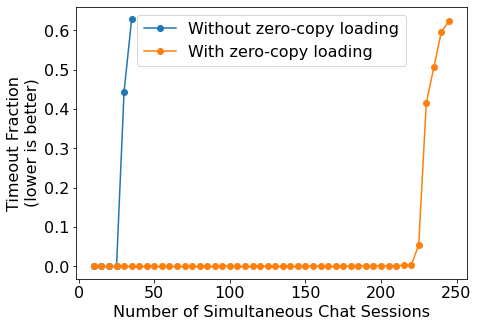

In [52]:
# Don't include this code in the blog, but do include the chart.
# Plot the two sets of results against each other.
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(7, 5))
plt.plot(baseline_stats['num_users'],
         baseline_stats['timeout_fraction'],
         '-o', label='Without zero-copy loading')
plt.plot(zerocopy_stats['num_users'],
         zerocopy_stats['timeout_fraction'],
         '-o', label="With zero-copy loading")
plt.xlabel('Number of Simultaneous Chat Sessions')
plt.ylabel('Timeout Fraction\n(lower is better)')
plt.legend()

*Annotated copy of the above chart that doesn't change when this notebook is recomputed:*
![Performance graph](../images/zerocopy_perf.png)

The baseline deployment can handle up to 30 simultaneous chat sessions. Beyond 30 sessions, the number of timeouts increases rapidly and the system becomes unstable. The baseline deployment uses a fixed allocation of CPU and memory because it hasn't been extensively tuned. When there are more than 30 simulated customers on the line, the CPU resources that are dedicated to the model with the highest traffic can no longer keep up with the increasingly large bursts of chat messages. 

Our Ray-based deployment with zero-copy model loading, on the other hand, handles up to 220 sessions without any timeouts. This performance represents a 7x improvement in scalability without any tuning. The zero-copy based deployment is able to instantly retask the underlying hardware resources to whatever models are currently experiencing high traffic.

This result shows how zero-copy model loading gives you zero-effort performance tuning.

If you'd like to try this technology out yourself, try the `zerocopy` package (TODO: Link to PyPI once package is posted)


*All the code used in this blog post is available (TODO: link goes here)*

# Extra material not included in the blog post

## Model inference pipelines


With the `zerocopy` library's `extract_tensors()` and `call_model()` functions, you can apply zero-copy model loading to a Pytorch model with three lines of Python. But what about the end-to-end program that this model came from? 

Most machine learning models require additional code to apply them in a meaningful way. NLP models in particular require *preprocessing* to convert natural language text into a format the model can understand and *postprocessing* to convert the model's answer into a format that a person can understand. 

Some models provide this preprocessing and postprocessing code as simple reference code, with the intent that someone will copy that initial version of the code and turn it into a full production-ready application.

It's also common to package the model as *pipeline* that includes preprocessing, inference, and postprocessing bundled together in a single Python object. For example, the Transformers library's BERT model that we have been using in our examples so far comes with a pipeline that performs the end-to-end task of *masked language modeling*: Identifying the most likely word to fill in a blank.

Unlike the "example reference code" approach, the Pipelines API's end-to-end inference code is intended for direct production use. It includes support for model retraining, as well as performance optimizations like batching and GPU acceleration, plus code for handling corner cases like long input strings. This prepackaged code can save a lot of time, provided that your application is structured in a way that can easily accomodate a large block of non-modifiable third-party Python code.

In [ ]:
bert_pipeline = transformers.pipeline('fill-mask', model='bert-base-uncased')
bert_pipeline('All your base are belong to [MASK].')

The `zerocopy` library includes a function `rewrite_pipeline` that transforms any models embedded into Python object into Ray tasks that use zero-copy model loading to load weights. If we apply this function to a pipeline, the resulting rewritten pipeline faithfully performs all the preprocessing and postprocessing that the original pipeline performed. However, this rewritten pipeline runs the embedded PyTorch model in remote Ray tasks.

In [ ]:
from pympler import asizeof

zero_copy_bert_pipeline = zerocopy.rewrite_pipeline(bert_pipeline)
print(f"Heap memory used before rewrite: {asizeof.asizeof(bert_pipeline)}")
print(f" Heap memory used after rewrite: {asizeof.asizeof(zero_copy_bert_pipeline)}")

print(f"Output before rewrite: {bert_pipeline('All your base are belong to [MASK].')[0]['score']}")
print(f" Output after rewrite: {zero_copy_bert_pipeline('All your base are belong to [MASK].')[0]['score']}")

In [ ]:
# Don't include this cell in the blog.
# Alternate version uses a multithreaded actor to run the pipeline via
# its __call__ method.

@ray.remote
class PipelineActor:
    '''
    Threaded Ray actor
    '''
    def __init__(self):
        transformers.logging.set_verbosity_error()
        pipeline_tmp = transformers.pipeline('fill-mask', model='bert-base-uncased')
        self._pipeline = zerocopy.rewrite_pipeline(pipeline_tmp)

    def run(self, input_: str):
        # Model inference calls inside this pipeline will happen in remote
        # Ray tasks.
        return self._pipeline(input_)


@serve.deployment
class MyDeployment2:
    def __init__(self):
        self._pipeline_actor = PipelineActor.options(max_concurrency=100,
                                                     num_cpus=0.1).remote()

    async def __call__(self, request: starlette.requests.Request):
        json_request = await request.json()
        input_ = json_request['input']

        result = await self._pipeline_actor.run.remote(input_)
        return result

MyDeployment2.options(name='my_model2', ray_actor_options={"num_cpus": 0.1}).deploy()

print(requests.put('http://127.0.0.1:8000/my_model2', 
      '{ "input": "All your base are belong to [MASK]." }').text)

In [ ]:
# Don't include this cell in the blog.
# Alternate version uses a thread pool and acyncio's run_in_executor()
# method run the pipeline via its __call__ method.

@serve.deployment
class MyDeployment3:
    def __init__(self):
        transformers.logging.set_verbosity_error()
        pipeline_tmp = transformers.pipeline('fill-mask', model='bert-base-uncased')
        self._pipeline = zerocopy.rewrite_pipeline(pipeline_tmp)

        self._threadpool = concurrent.futures.ThreadPoolExecutor()

    async def __call__(self, request: starlette.requests.Request):
        '''
        Web service entry point.

        Args:
            request: HTTP request object for a REST web service call
                     in the form:
                     { "input": "<input text with [MASK]>" }
        '''
        # Parse JSON. A real deployment would also sanitize the input.
        json_request = await request.json()
        masked_string = json_request['input']

        # The original `transformers` code is not async-aware, so we
        # call it from `run_in_executor()`.
        # Preprocessing and postprocessing code will happen inside this
        # process, but model inference will occur in a remote Ray task.
        # While that task is running, the local thread will block on
        # a call to `ray.get()`
        result = await asyncio.get_running_loop().run_in_executor(
             self._threadpool, lambda: self._pipeline(masked_string))
        return result

MyDeployment3.options(name='my_model3', ray_actor_options={"num_cpus": 0.1}).deploy()

print(requests.put('http://127.0.0.1:8000/my_model3', 
      '{ "input": "All your base are belong to [MASK]." }').text)